In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
from tqdm import tqdm
%matplotlib inline

In this notebook we get to know CartPole environment from gym package and implement ES algorithm on it.

## 0. CartPole Env

### 0.1. Environment discription

In [3]:
import gym

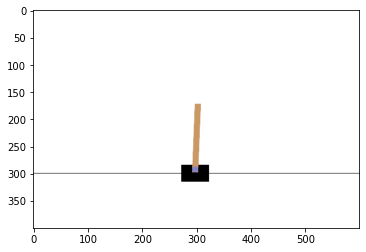

In [13]:
tmp_env = gym.make("CartPole-v1")
tmp_env.reset()
plt.imshow(tmp_env.render('rgb_array'))

In [18]:
print("OBSERVATION SPACE: \n {}".format(tmp_env.observation_space))
print("\n")
print("ACTION SPACE: \n {}".format(tmp_env.action_space))

OBSERVATION SPACE: 
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


ACTION SPACE: 
 Discrete(2)


We see that each observation is given space is given by 4 magnitudes:

1. cart position
2. cart velocity 
3. pole angle
4. pole angular velocity

At the same time, we have just 2 actions:

1. move right 
2. move left

In [21]:
state_size = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

print("State size: {}".format(state_size))
print("Actions size: {}".format(n_actions))

State size: 4
Actions size: 2


### 0.1. Interaction with environment

In [29]:
initial_state = tmp_env.reset()

print("NOW WE HAVE: \n")
print("Initial state is: {}".format(initial_state))

#make step in environment
new_state, reward, done, _ = tmp_env.step(0)

print('\n')
print("AFTER ONE STEP WE GET: \n")

print("New state: {}".format(new_state))
print("Reward: {}".format(reward))
print("The game is over? --  {}".format(done))

NOW WE HAVE: 

Initial state is: [-0.0408659  -0.01876177 -0.02004804 -0.02952263]


AFTER ONE STEP WE GET: 

New state: [-0.04124114 -0.21359058 -0.02063849  0.2567681 ]
Reward: 1.0
The game is over? --  False


### 0.3 Random agent 

Before applying the ES algorithm lets look at perfomance of an agent which acts randomly.

In [32]:
class RandomAgent:
    def __init__(self, n_actions):
        self.n_actions = n_actions
    
    def get_action(self, state):
        return np.random.choice(self.n_actions)

### 0.3 Sessions display 

In [33]:
def display_session(env, agent, t_max = 500):
    """
    Displays an episode. 
    
    Args:
        env: gym environment
        agent: agent which interacts with environment
        t_max: trajectory length
    """
    plt.figure(figsize=(6, 5))
    display.clear_output(wait=True)
    
    
    total_reward = 0
    state = env.reset()
    
    for t in range(t_max):
        plt.gca().clear()
        
        action = agent.get_action(torch.tensor(state).float())
        new_state, reward, done, _ = env.step(action)
        state = new_state
        
        total_reward += reward
        
        plt.imshow(env.render('rgb_array'))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            break
            
    return total_reward

Total reward: 31.0


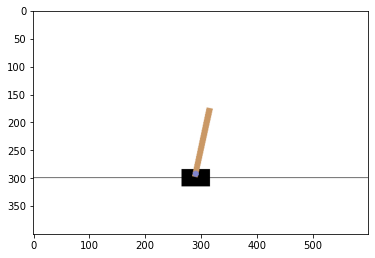

In [37]:
total_reward = display_session(tmp_env, RandomAgent(n_actions))
print('Total reward: {}'.format(total_reward))

### 0.4 Evaluation

In [74]:
def generate_session(env, agent, t_max=500):
    """
    Generates one session. 
    
    Args:
        env: gym environment
        agent: agent which interacts with environment
        t_max: trajectory length
        
    Returns:
        total_reward: total episode reward 
    """
    total_reward = 0
    state = env.reset()
    
    for t in range(t_max):
        action = agent.get_action(torch.tensor(state).float())
        new_state, reward, done, info = env.step(action)
        total_reward += reward
        state = new_state
        
        if done:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=500):
    """
    Calculates total score for given number of generated sessions n and 
    length of trajectory t_max. 
    
    Args:
        env: gym environment
        agent: agent which interacts with environment
        n: number of generated session 
        t_max: trajectory length
    
    Returns:
        total_reward: average for all episodes reward
    """
    
    rewards = [generate_session(env, agent, t_max=t_max) for _ in range(n)]
    return sum(rewards) / n

In [75]:
n = 10
t_max = 500
reward = score(tmp_env, RandomAgent(n_actions), n, t_max)
print('Mean reward for {} games with random agent policy: {}'.format(n, total_reward))

Mean reward for 10 games with random agent policy: 31.0


---

## 1. Evaluation strategies

In [41]:
def add_noise_to_model(model, noise, copy=False):
    """
    Add noise to the parameters of our model (agent). 
    
    Args:
        model: maps the sates into the actions (i.e. agent)
        noise: noise which we add to parameters
        copy: whether to make a new copy of the model
    """
    if copy:
        new_model = deepcopy(model)
    else:
        new_model = model
        
    for param, noise_param in zip(new_model.parameters(), noise):
        param.data += noise_param

    return new_model

In [126]:
np.random.seed(2022)

In [157]:
class EvolutioinStrategies:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, n_threads = 1, normalize=True):
        super().__init__()
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        self.n_threads = n_threads
        self.env = get_env_function()
        
        
    def get_noised_model(self, model):
        """
        Generate noise and adds it to the model.
        
        Args:
            model: maps the sates into the actions (i.e. agent)
        
        Returns:
            model with noise and noise itself.
        """
        noise = []
        for param in model.parameters():
            noise.append(self.std * torch.randn(param.shape))
            
        return add_noise_to_model(model, noise, copy=True), noise
    
    def normalize_rewards(self, rewards):
        """
        Normalizes rewards. 
        
        Args:
            rewards: model rewards               
        """
        rewards = (rewards - torch.mean(rewards)) / torch.std(rewards)
        return rewards

    
    def optimize(self, model, noises, rewards):
        """
        Updates weights by adding the combined (weighted) noise. 
        
        Args:
            model: maps the sates into the actions (i.e. agent)
            noises: list of vectors of noises 
            rewards: rewards                
        """
        if self.normalize:
            rewards = self.normalize_rewards(rewards)
        
        combined_noise = []
        for i in range(len(list(model.parameters()))):
            cat_noise = torch.cat([n[i].unsqueeze(n[i].dim()) for n in noises], dim=-1)
            combined_noise.append(torch.sum(rewards * cat_noise / self.std, dim=-1))
            combined_noise[-1] *= self.lr / (len(noises) * self.std)

        add_noise_to_model(model, combined_noise)
    
    
    def step(self, model):
        """
        Calculates rewards and makes an optimizing step.
        
        Args:
            model: maps the sates into the actions (i.e. agent)
        """
        st = time.time()
        rewards = []
        noises = []
        noised_models = []
        for i in range(self.n_samples):
            noised_model, noise = self.get_noised_model(model)
            noised_models.append(noised_model)
            noises.append(noise)
        
        if self.n_threads == 1:
            rewards = [score(self.env, noised_models[i]) for i in range(self.n_samples)]
        else:
            rewards = np.array(Parallel(n_jobs=self.n_threads)(delayed(score)(deepcopy(self.env), noised_models[i]) 
                                                               for i in range(self.n_samples)))
        
        self.optimize(model, noises, torch.tensor(rewards))
        self.update_log(rewards)
        
    def update_log(self, rewards):
        """
        Logs new rewards.
        """
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()
    

In [158]:
class MLPPolicy(nn.Module):
    """
    Agent as a NN. Maps a state to an action. 
    """
    def __init__(self, n_features, n_actions, n_hiddens, discrete = False):
        super().__init__()
        self.discrete = discrete
        
        layers = []
        # use two linear layers
        layers.append(nn.Linear(n_features, n_hiddens, bias=False))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(n_hiddens, n_actions, bias=False))
        
        self.model = nn.Sequential(*layers)

        for param in self.parameters():
            param.data *= 0
            param.requires_grad = False
        
    def get_action(self, state):
        """
        Gets an action from the state. Takes argmax (most likely) action. 
        """
        with torch.no_grad():
            model_output = self.model(state)

        if self.discrete:
            return np.argmax(model_output.detach().numpy())
        
        return model_output.numpy()

In [159]:
def get_env_function():
    """
    Generates an instance of environment and returns it.
    """
    env = gym.make('CartPole-v0').env
    return env

In [152]:
tmp_env = get_env_function()

In [153]:
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

**Not parallelized version**

In [154]:
#agent will be with 64 hidden neurons.
model = MLPPolicy(n_states, n_actions, 64, discrete=True)

In [160]:
algorithm = EvolutioinStrategies(get_env_function, std=0.01, lr=0.001, n_threads = 1, n_samples=128)

last mean reward = 485.884


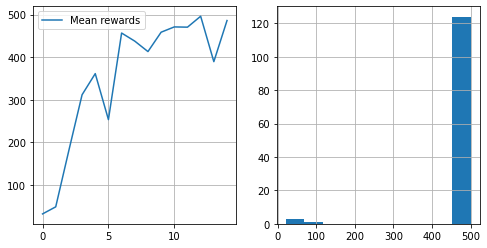

15.636188983917236


In [156]:
for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

500.0

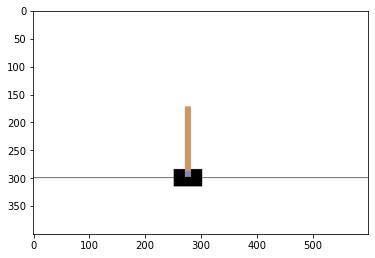

In [161]:
display_session(tmp_env, model, t_max=500)

**Parallelized version**

In [162]:
model = MLPPolicy(n_states, n_actions, 64, discrete=True)

In [163]:
algorithm = EvolutioinStrategies(get_env_function, std=0.01, lr=0.001, n_threads = 16, n_samples=128)

last mean reward = 491.908


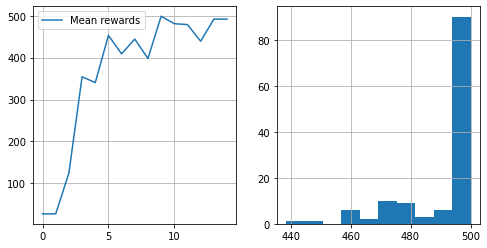

23.596701860427856


In [164]:
for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

500.0

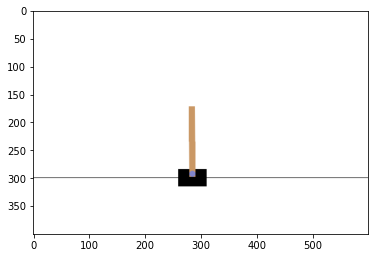

In [165]:
display_session(tmp_env, model, t_max=500)